In [1]:
import pandas as pd
from sklearn import datasets
import numpy as np
import math
import matplotlib.pyplot as plt
from K_means import *
from sklearn.datasets import make_blobs
from numpy import dot
from numpy.linalg import norm
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler, normalize
from scipy.sparse.linalg import eigs, eigsh
from scipy.spatial.distance import cdist
from sklearn.impute import KNNImputer
from sklearn.metrics import rand_score
from spectral_fonctions import *

In [2]:
import os
os.chdir('../')

import pandas as pd
from typing import Literal
import time

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Fonction k_means_quality_test pour faire plusieurs tests à la fois 

In [4]:
from sklearn.decomposition import PCA
from sklearn.metrics import rand_score

def k_means_quality_test(df: pd.DataFrame, ground_truth_labels, n_clusters: int, nb_estimators: int, init_method: Literal['kmeans++', 'random-partition', 'guided_PCA', 'forgy']):
    """
    returns a list with the inertia values of the nb_estimators times the kmeans algorithm 
    """
    inertia_values, accuracy_values = [], []

    # technicality to avoid recalculating the PCA reduction at each iteration
    if init_method == 'guided_PCA':
        pca = PCA(n_components=n_clusters)
        df_pca = pca.fit_transform(df.values)

    for i in range(nb_estimators):
        if init_method == 'guided_PCA':
            kmeans = generalized_Kmeans(k=n_clusters, init=init_method, df_PCA=df_pca, model_PCA=pca)
        else:
            kmeans = generalized_Kmeans(k=n_clusters, init=init_method)
        kmeans.fit(df.values)
        cluster_labels = kmeans.predict(df.values)

        # Obtain the inertia
        inertia_values.append(kmeans.loss_)

        accuracy_values.append(rand_score(cluster_labels, ground_truth_labels))

    return sorted(inertia_values, reverse=True), sorted(accuracy_values)

In [5]:
# Technical functions for fast execution with a big number of iterations

from sklearn.metrics import rand_score

def multi_final_spectral_clustering_regular(nb_estimators: int, data, ground_truth_labels, similarity_function, k_nearest_neighboors, number_of_clusters, weighted : bool, eigensolver) :

    spectral_clustering_inertia_values, spectral_clustering_accuracy_values = [], []

    W = KNN_adjacency_matrix(data, similarity_function, k_nearest_neighboors, weighted)
    L = regular_laplacian(W)

    U = eigensolver(L, number_of_clusters)

    for i in range(nb_estimators):

        kmeans = generalized_Kmeans(k=number_of_clusters, init='forgy', epochs=10, random_seed=0)
        kmeans.fit(U)

        labels = kmeans.predict(U)

        spectral_clustering_inertia_values.append(loss_inertia(labels, data))
        spectral_clustering_inertia_values.sort(reverse=True)

        spectral_clustering_accuracy_values.append(rand_score(labels, ground_truth_labels))
        spectral_clustering_accuracy_values.sort()


    return spectral_clustering_inertia_values, spectral_clustering_accuracy_values

def multi_final_spectral_clustering_rw(nb_estimators: int, data, ground_truth_labels, similarity_function, k_nearest_neighboors, number_of_clusters, weighted : bool, eigensolver) :

    spectral_clustering_inertia_values, spectral_clustering_accuracy_values = [], []

    W = KNN_adjacency_matrix(data, similarity_function, k_nearest_neighboors, weighted)
    L = laplacian_rw(W)

    U = eigensolver(L, number_of_clusters)

    for i in range(nb_estimators):

        kmeans = generalized_Kmeans(k=number_of_clusters, init='forgy', epochs=10, random_seed=0)
        kmeans.fit(U)

        labels = kmeans.predict(U)

        spectral_clustering_inertia_values.append(loss_inertia(labels, data))
        spectral_clustering_inertia_values.sort(reverse=True)

        spectral_clustering_accuracy_values.append(rand_score(labels, ground_truth_labels))
        spectral_clustering_accuracy_values.sort()


    return spectral_clustering_inertia_values, spectral_clustering_accuracy_values


## MNIST df (from the article)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn import metrics

# Load MNIST dataset from scikit-learn
mnist = fetch_openml('mnist_784')
data = mnist.data
labels = mnist.target.astype(int)
data['label'] = labels

In [18]:
# We do the experiment in the same conditions of the article
# Keep only the first 50 instances of each class
df_MNIST = data.groupby('label').head(50).reset_index(drop=True)
temp = df_MNIST['label'].values

# center the data
df_MNIST = df_MNIST - df_MNIST.mean(axis=0)
df_MNIST['label'] = temp

### 1000 itertations for every clustering method

In [20]:
start_time = time.time()
spectral_clustering_inertia_values, spectral_clustering_accuracy_values = multi_final_spectral_clustering_rw(1000, df_MNIST.values, df_MNIST['label'].values, euclidian_similarity_function, k_nearest_neighboors= 7, number_of_clusters= 10, weighted=True, eigensolver= compute_matrix_U_ARPACK)
end_time = time.time()
execution_time_spectral_clustering = end_time - start_time

In [21]:
start_time = time.time()
kmeans_guided_PCA_inertia_values, kmeans_guided_PCA_accuracy_values = k_means_quality_test(df_MNIST, df_MNIST['label'].values, n_clusters=10,  nb_estimators=1000, init_method='guided_PCA')
end_time = time.time()
execution_time_guided_PCA = end_time - start_time

In [22]:
start_time = time.time()
kmeans_plus_plus_inertia_values, kmeans_plus_plus_accuracy_values = k_means_quality_test(df_MNIST, df_MNIST['label'].values, n_clusters=10, nb_estimators=1000, init_method='kmeans++')
end_time = time.time()
execution_time_plus_plus = end_time - start_time

In [23]:
start_time = time.time()
kmeans_forgy_inertia_values, kmeans_forgy_accuracy_values = k_means_quality_test(df_MNIST, df_MNIST['label'].values, n_clusters=10, nb_estimators=1000, init_method='forgy')
end_time = time.time()
execution_time_forgy = end_time - start_time

In [24]:
start_time = time.time()
kmeans_random_partition_inertia_values, kmeans_random_partition_accuracy_values = k_means_quality_test(df_MNIST, df_MNIST['label'].values, n_clusters=10, nb_estimators=1000, init_method='random-partition')
end_time = time.time()
execution_time_random_partition = end_time - start_time

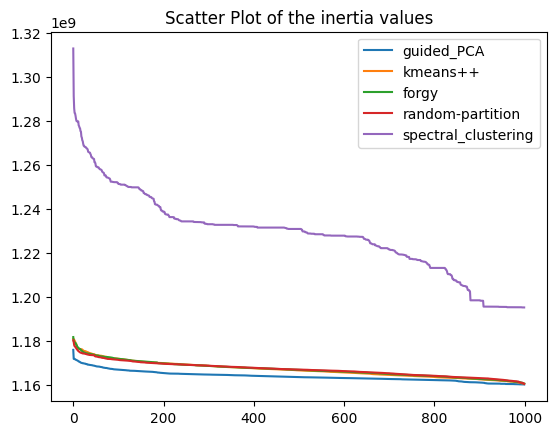

In [25]:
import matplotlib.pyplot as plt

x = list(range(len(kmeans_guided_PCA_inertia_values)))

# scatter plot
plt.plot(x, kmeans_guided_PCA_inertia_values, label='guided_PCA')
plt.plot(x, kmeans_plus_plus_inertia_values, label='kmeans++')
plt.plot(x, kmeans_forgy_inertia_values, label='forgy')
plt.plot(x, kmeans_random_partition_inertia_values, label='random-partition')
plt.plot(x, spectral_clustering_inertia_values, label='spectral_clustering')

# add the title and the legend
plt.legend()
plt.title('Scatter Plot of the inertia values')

# plot the graph
plt.show()


In [29]:
print(f'min inertia of spectral_clustering = {min(spectral_clustering_inertia_values)} \n and execution time is {execution_time_spectral_clustering}')
print(f'min inertia of kmeans_guided_PCA = {min(kmeans_guided_PCA_inertia_values)} \n and execution time is {execution_time_guided_PCA}')
print(f'min inertia of kmeans++ = {min(kmeans_plus_plus_inertia_values)} \n and execution time is {execution_time_plus_plus}')
print(f'min inertia of kmeans_forgy = {min(kmeans_forgy_inertia_values)}  \n and execution time is {execution_time_forgy}')
print(f'min inertia of kmeans_random_partition = {min(kmeans_random_partition_inertia_values)} \n and execution time is {execution_time_random_partition}')

min inertia of spectral_clustering = 1195138693.400064 
 and execution time is 39.71408200263977
min inertia of kmeans_guided_PCA = 1160079044.3066387 
 and execution time is 42.29283809661865
min inertia of kmeans++ = 1160471901.5924778 
 and execution time is 407.57798290252686
min inertia of kmeans_forgy = 1160460423.5753608  
 and execution time is 322.9634540081024
min inertia of kmeans_random_partition = 1160338159.5894063 
 and execution time is 337.8829550743103


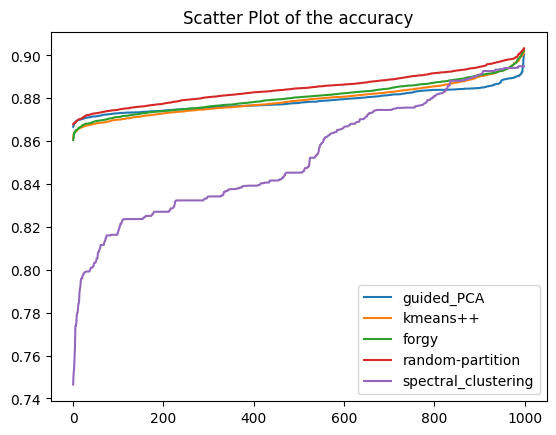

In [26]:
import matplotlib.pyplot as plt

x = list(range(len(kmeans_guided_PCA_accuracy_values)))

# scatter plot
plt.plot(x, kmeans_guided_PCA_accuracy_values, label='guided_PCA')
plt.plot(x, kmeans_plus_plus_accuracy_values, label='kmeans++')
plt.plot(x, kmeans_forgy_accuracy_values, label='forgy')
plt.plot(x, kmeans_random_partition_accuracy_values, label='random-partition')
plt.plot(x, spectral_clustering_accuracy_values, label='spectral_clustering')

# add the title and the legend
plt.legend()
plt.title('Scatter Plot of the accuracy')

# plot the graph
plt.show()

In [28]:
print(f'max accuracy of spectral_clustering = {max(spectral_clustering_accuracy_values)}')
print(f'max accuracy of kmeans_guided_PCA = {max(kmeans_guided_PCA_accuracy_values)}')
print(f'max accuracy of kmeans++ = {max(kmeans_plus_plus_accuracy_values)}')
print(f'max accuracy of kmeans_forgy = {max(kmeans_forgy_accuracy_values)}')
print(f'max accuracy of kmeans_random_partition = {max(kmeans_random_partition_accuracy_values)}')

max accuracy of spectral_clustering = 0.894941883767535
max accuracy of kmeans_guided_PCA = 0.9003366733466934
max accuracy of kmeans++ = 0.9018436873747495
max accuracy of kmeans_forgy = 0.9031503006012024
max accuracy of kmeans_random_partition = 0.9032224448897795
